## Barren Plateau Problems

In [74]:
import qiskit as qk
from qiskit import Aer, QuantumCircuit

from qiskit.circuit import Parameter, ClassicalRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigen_solvers.vqe import VQEResult
from qiskit.algorithms.optimizers import COBYLA
from typing import Tuple, List, Dict, Union
from scipy.optimize import minimize, OptimizeResult
import numpy as np
from random import random
import json
from pprint import pprint
import matplotlib.pyplot as plt
from operator import truediv
%matplotlib inline

N_QUBIT_NO_MUB_PATH = 'no_mub_results_n.txt'
NO_MUB_PATH = 'no_mub_results_3.txt'
PRE_MUB_PATH = 'prepend_mub_results_3.txt'
APP_MUB_PATH = 'append_mub_results.txt'

NO_TOL = 0
LO_TOL = 1e-5
HI_TOL = 0.2
LO_CORR_THRESHOLD = 0.1
HI_CORR_THRESHOLD = 0.4
N_QUBITS = 3

SHOTS = 8192
MAX_ITER = 1e8
backend = Aer.get_backend('qasm_simulator')
qi = QuantumInstance(backend, shots=SHOTS)

### Basic Barren Plateau Circuit for Variational Quantum Compilation

The "Cerezo" ansatz circuit is taken from "Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits" by Cerezo et al., 2021, Figure 4.
The "Arrasmith" ansatz circuit is taken from "Effect of barren plateaus on gradient-free optimization" by Arrasmith et al. (2021).

The attempted task is "trivial" Variational Quantum Compilation.
Vartational Quantum Compilation gets some unitary $U$, and an ansatz $V(\theta)$, and attempts to find a value for $\theta$ such that $V(\theta)| 0 \rangle = U | 0 \rangle$.

In this case, we choose $U=I$.
Because we pick a *random* initial guess for $\theta$, we will experience the barren plateaus that occur when the $\theta$ values are away from the target.

Note, however, an important observation:
In order to actually use the "value" of the different MUB starting points, the original value of the parameters needs to be constant (although random) for all experiments.

I took this specific problem from "Effect of barren plateaus on gradient-free optimization" by Arrasmith et al. (2021).

In [75]:
def gen_vqc_ansatz_cerezo(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)

    idx = 0

    for i in range(n_qubits):
        theta = Parameter(f'theta_{idx}')
        idx += 1
        qc.ry(theta, i)
        

    for layer in range(n_layers):
        for i in range(0, n_qubits-1, 2):
            qc.cz(i, i+1)
        
        for i in range(n_qubits-1):
            theta1 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta1, i)

        for i in range(1, n_qubits-1, 2):
                qc.cz(i, i+1)
            
        for i in range(1, n_qubits):
            theta2 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta2, i)

    qc.measure_all()

    return qc


def gen_vqc_ansatz_arrasmith(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)
    count=1
    for _ in range(n_layers):
        
        # First layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        # First layer of even CXs
        for i in range(0, n_qubits-1, 2):
            qc.cx(i, i+1)
            
        # Second layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        for i in range(1, n_qubits, 2):
            qc.cx(i, (i+1)%n_qubits)
            
    qc.measure_all()
        
    return qc


### Experimenting without MUBs

#### Experiment Functions

In [76]:
# Returns the number of function evaluations it took for the method to converge.
# If during the optimization, the cost function goes below a specified bound, the optimization halts.
# If the optimization halted because of the bound, the OptimizeResult is replaced with None.
def run_vqc_exp(qc: QuantumCircuit, theta0: List[float], tol: float = HI_TOL, success_bound: float=0) -> Tuple[List[float], OptimizeResult]:
    class BoundHitException(Exception):
        pass
    
    cost_points = []
    def get_val_from_theta(theta: List[float]) -> float:
        concrete_qc = qc.bind_parameters(theta)
        results = qi.execute(concrete_qc)
        resval = 1 - (results.get_counts().int_raw.get(0, 0) / SHOTS)
        cost_points.append(resval)
        if (resval) <= success_bound:
            print('WOOP')
            raise BoundHitException()
        return resval

    try:
        res = minimize(get_val_from_theta,
            theta0,
            method='COBYLA',
            options={'maxiter': MAX_ITER},
            tol=tol)
        
    except BoundHitException:
        return cost_points, None

    return cost_points, res



#### Experiments

In [66]:
# Ad-hoc. Want to see when does the process stop when you give it a LOT of time.

n_layers=8
print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
qc = gen_vqc_ansatz_arrasmith(n_layers, n_layers)
theta0 = [np.random.random() for _ in range(qc.num_parameters)]
layer_res = run_vqc_exp(qc, theta0, NO_TOL, success_bound=HI_CORR_THRESHOLD)

RUNNING EXPERIMENT FOR 8 LAYERS:


ZeroDivisionError: Binding provided for expression results in division by zero (Expression: theta_1, Bindings: {Parameter(theta_1): inf}).

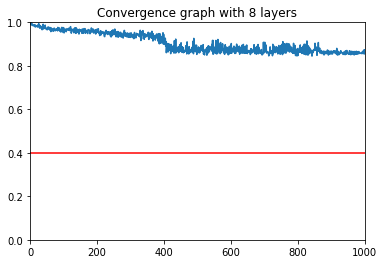

In [65]:
data = layer_res
plt.axis([0, len(data), 0, 1])
plt.plot(data)
plt.title(f'Convergence graph with 8 layers')
plt.plot([0, len(data)-1], [0.4, 0.4], color='red')
plt.show()

### 3-qubit, n-layer experiments

In [77]:
no_mub_res = {}
for n_layers in range(4, 13):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz_arrasmith(N_QUBITS, n_layers)
    theta0 = [np.random.random() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, theta0, NO_TOL, success_bound=HI_CORR_THRESHOLD)

    no_mub_res[n_layers] = layer_res

RUNNING EXPERIMENT FOR 4 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 5 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 6 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 7 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 8 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 9 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 10 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 11 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 12 LAYERS:
WOOP


### n-qubit, n-layer experiments

In [91]:
n_qubit_no_mub_res = {}
for n_layers in range(8, 13):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz_arrasmith(n_layers, n_layers)
    theta0 = [np.random.random() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, theta0, NO_TOL, success_bound=HI_CORR_THRESHOLD)

    n_qubit_no_mub_res[n_layers] = layer_res

RUNNING EXPERIMENT FOR 8 LAYERS:


### Analysis Functions

In [88]:
def avg(col):
    return sum(col) / len(col) if len(col) > 0 else None

def wavg(col, weights):
    assert len(col) == len(weights)
    return sum([v * w for v,w in zip(col, weights)])


def nfev(data: Tuple[List[float], Union[VQEResult, OptimizeResult]]) -> int:
    evals, record = data
    if evals != []:
        return len(evals)
    elif type(record) == VQEResult:
        return record.cost_function_evals
    else:
        assert type(record) == OptimizeResult
        return record.nfev
    
    
def fin_val(data: Tuple[List[float], Union[VQEResult, OptimizeResult]]) -> int:
    evals, record = data
    if evals != []:
        return evals[-1]
    elif type(record) == VQEResult:
        return record.eigenvalue
    else:
        return record.fun


def gen_statistics_nomub(results_dict: Dict[int, Tuple[List[float], VQEResult]], filename: str = NO_MUB_PATH):
    res = {l: {'nfev': nfev(res), 'fin_val': fin_val(res), 'evals': res[0]} for l, res in results_dict.items()}
    with open(filename, 'w') as f:
        pprint(res, f)
    return res

#### Analysis

In [89]:
filename = os.path.join(os.getcwd(), 'VQC results', NO_MUB_PATH)
no_mub_stats = gen_statistics_nomub(no_mub_res, filename=filename)

filename = os.path.join(os.getcwd(), 'VQC results', N_QUBIT_NO_MUB_PATH)
n_qubit_no_mub_stats = gen_statistics_nomub(n_qubit_no_mub_res, filename=filename)

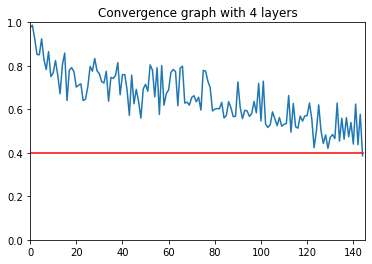

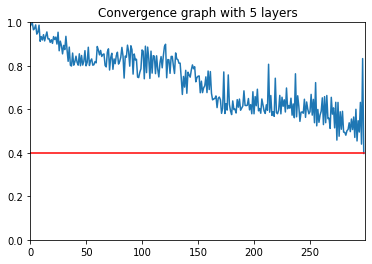

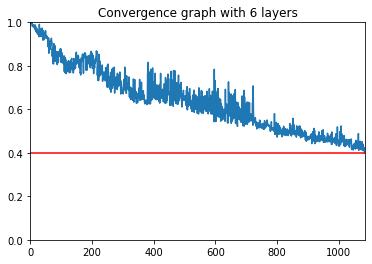

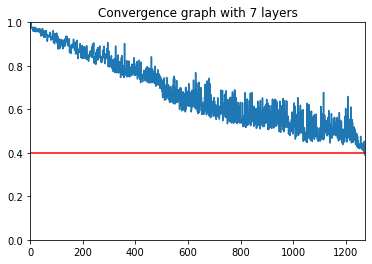

In [90]:
for l, data in n_qubit_no_mub_stats.items():
    plt.axis([0, len(data['evals']), 0, 1])
    plt.plot(data['evals'])
    plt.title(f'Convergence graph with {l} layers')
    plt.plot([0, len(data['evals'])-1], [0.4, 0.4], color='red')
    plt.show()

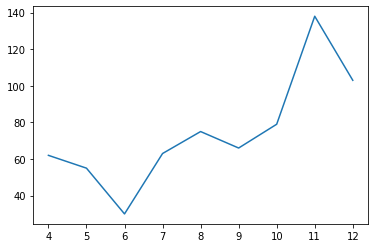

In [85]:
plt.plot(n_qubit_no_mub_stats.keys(), [v['nfev'] for v in n_qubit_no_mub_stats.values()])
plt.show()

In [ ]:
filename = os.path.join(os.getcwd(), 'VQC results', NO_MUB_PATH)
no_mub_stats = gen_statistics_nomub({k: v[0] for k,v in no_mub_res.items()}, filename=filename)

for k, v in no_mub_res.items():
    plt.plot(v[1])
    plt.plot([0, len(v[1])], [HI_CORR_THRESHOLD, HI_CORR_THRESHOLD], color='red')
    plt.title(f'{k} layers and qubits convergence graph, no MUBs')

In [14]:
filename = os.path.join(os.getcwd(), 'VQC results', 'no_mub_results_n.txt')
n_qubit_no_mub_stats = gen_statistics_nomub({k: v[0] for k,v in n_qubit_no_mub_res.items()}, filename=filename)
with open('VQC results/no_mub_graphs_n.txt', 'w') as f:
    f.write(str({k: v[1] for k,v in n_qubit_no_mub_res.items()}))


## Mitigating Barren Plateaus using MUBs

### Loading the QASM MUB circuits into Qiskit

In [102]:
CIRC_FROM_FILES = True
if CIRC_FROM_FILES:
    paths = os.listdir(MUB_CIRC_3_PATH)
    circuits = [qk.circuit.QuantumCircuit.from_qasm_file(os.path.join(MUB_CIRC_3_PATH,path)) for path in paths if '.txt' in path]
else:
    circuits = [qk.circuit.QuantumCircuit.from_qasm_str(qasm_str) for qasm_str in qasm_3_306.values()]
    

### Experimenting with MUBs - prepending
This is an experiment in which a MUB transformation is applied *before* the ansatz circuits.

#### Experiment Functions

In [103]:
# This function gets a number i from 0 to (2^n)-1
# and returns a circuit that generates the state |i> when acting on |0>.
def get_comp_state_circ(state_idx: int, n_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    bin_str = bin(state_idx)[2:].zfill(n_qubits)
    for i, ch in enumerate(bin_str):
        if ch == '1':
            qc.x(i)
    return qc

def run_vqc_exp_with_mub_prepend(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit, n_qubits: int, n_layers: int, theta0: List[float], tol: float = 0.2) -> dict:
    mub_qc = mub_qc.copy()
    mub_qc.add_register(ClassicalRegister(n_qubits))
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None

    res_dict = {}
    for i in range((2 ** n_qubits)):
        starting_qc = get_comp_state_circ(i, n_qubits)
        starting_qc.add_register(ClassicalRegister(n_qubits))
        full_qc = starting_qc.compose(mub_ansatz_qc, qubits=range(n_qubits), inplace=False)
        assert full_qc != None
        #TODO: integrate res tracking into prepended MUB states as well
        res_dict[i], _ = run_vqc_exp(full_qc, theta0, tol)

    return res_dict

#### Experiments: try all MUB states

In [ ]:
print('=====Experimenting with prepended MUB states=====')
all_prepend_mub_results = {}
for n_layers in range(4,13):
    layer_results = {}
    print(f'---experimenting with {n_layers} layers---')
    ansatz = gen_vqc_ansatz_cerezo(n_qubits, n_layers)
    theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    for i, mub_circuit in enumerate(circuits):
        print(f'experimenting with MUB #{i+1}')
        res = run_vqc_exp_with_mub_prepend(ansatz, mub_circuit, N_QUBITS, n_layers, theta0, tol=LO_TOL)
        # print(res)
        print(f'MUB #{i+1} done')
        for state, state_data in res.items():
            layer_results[(i, state)] = state_data
        # layer_results[i] = res
    all_prepend_mub_results[n_layers] = layer_results

## Check which MUBs have result smaller than 0.1

In [59]:
for key in all_prepend_mub_results.keys():
    for key2 in all_prepend_mub_results[key].keys():
        for key3 in all_prepend_mub_results[key][key2].keys():
            if all_prepend_mub_results[key][key2][key3].fun < 0.1:
                print("num of layers: " + str(key), "MUB number: " + str(key2), "State number: " + str(key2), 
                      "function evaluations: " + str(all_prepend_mub_results[key][key2][key3].nfev))

num of layers: 4 MUB number: 2 State number: 2 function evaluations: 82
num of layers: 4 MUB number: 2 State number: 2 function evaluations: 83
num of layers: 4 MUB number: 2 State number: 2 function evaluations: 79
num of layers: 4 MUB number: 2 State number: 2 function evaluations: 96
num of layers: 4 MUB number: 2 State number: 2 function evaluations: 87
num of layers: 4 MUB number: 2 State number: 2 function evaluations: 103
num of layers: 4 MUB number: 2 State number: 2 function evaluations: 91
num of layers: 4 MUB number: 4 State number: 4 function evaluations: 83
num of layers: 4 MUB number: 4 State number: 4 function evaluations: 68
num of layers: 4 MUB number: 4 State number: 4 function evaluations: 114
num of layers: 4 MUB number: 4 State number: 4 function evaluations: 94
num of layers: 4 MUB number: 4 State number: 4 function evaluations: 105
num of layers: 4 MUB number: 4 State number: 4 function evaluations: 72
num of layers: 4 MUB number: 4 State number: 4 function evalu

### Analysis Functions

In [ ]:
# Analyze the performance of using MUB states as initial states for an ansatz
def gen_statistics_prepending(prepend_results_dict: Dict[int, Dict[int, Dict[int, Tuple[List[float], VQEResult]]]],
no_mub_stats: Dict[int, Dict[str, int]],
filename: str = APP_MUB_PATH) -> Dict[int, Dict[str, any]]:

    prepend_stats = {}
    for l, d_l in prepend_results_dict.items():
        layer_stats = {}
        min_nfev = min([min([nfev(state_data) for state_data in d_mub.values()]) for d_mub in d_l.values()])
        layer_stats['min_nfev'] = min_nfev
        # All MUBs have the same amount of states, so a repeated average is mathematically valid
        layer_stats['avg_nfev'] = avg([avg([nfev(state_data) for state_data in d_mub.values()]) for d_mub in d_l.values()])

        # Experiments with smaller convergence time
        adv_states = {}
        adv_states_flat = []
        for mub_idx, d_mub in d_l.items():
            adv_states[mub_idx] = {state: nfev(state_data) for state, state_data in d_mub.items() if nfev(state_data) < no_mub_stats[l]['nfev']}
            adv_states_flat += [nfev(state_data) for state_data in d_mub.values() if nfev(state_data) < no_mub_stats[l]['nfev']]
            
        layer_stats['adv_states'] = adv_states
        layer_stats['adv_states_count'] = len(adv_states_flat)
        layer_stats['adv_addition_percent'] = len(adv_states_flat) / ((2 ** N_QUBITS + 1) * (2 ** N_QUBITS))
        layer_stats['adv_avg_nfev'] = avg(adv_states_flat)
            
            
        # Experiments that terminated closer to the intended result
        correct_states = {}
        correct_states_flat = []
        all_fin_vals = []
        for mub_idx, d_mub in d_l.items():
            correct_states[mub_idx] = {state: fin_val(state_data) for state, state_data in d_mub.items() if fin_val(state_data) < LO_CORR_THRESHOLD}
            correct_states_flat += [fin_val(state_data) for state_data in d_mub.values() if fin_val(state_data) < LO_CORR_THRESHOLD]
            all_fin_vals += [fin_val(state_data) for state_data in d_mub.values()]
            
        layer_stats['correct_states_states'] = correct_states
        layer_stats['correct_states_count'] = len(correct_states_flat)
        layer_stats['correct_addition_percent'] = len(correct_states_flat) / ((2 ** N_QUBITS + 1) * (2 ** N_QUBITS))
        layer_stats['correct_avg_val'] = avg(correct_states_flat)
        
        layer_stats['fin_vals'] = all_fin_vals
        prepend_stats[l] = layer_stats

    with open(filename, 'w') as f:
        pprint(prepend_stats, f)

    return prepend_stats

#### Analysis

In [ ]:
filename = os.path.join(os.getcwd(), 'VQC results', PRE_MUB_PATH)
prepend_stats = gen_statistics_prepending(all_prepend_mub_results, no_mub_stats, filename=filename)

## Collective Experiments - VQC

### Plotting Functions

In [137]:
def myplot(data: dict, label: str):
    data = {k: v for k,v in data.items() if v != None}
    lists = sorted(data.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x, y, label=label, marker='o')

def myplot_heatmap(data: list, true_sol: float, false_sols: list = [], val_range=(-0.1, 0.7), bin_count=50, title=""):
    plt.hist(data, bin_count, range=val_range, color='blue')

    # Add Correct Result Line
    plt.plot([true_sol,true_sol], [0,10], color='green', linewidth=1)

    for val in false_sols:
        plt.plot([val, val], [0,10], color='red', linewidth=1)

    plt.title(title)
    plt.show()
    

### (Optionally) Load Data Fom Files

In [134]:
from ast import literal_eval

STATS_FROM_FILES = True

def load_stats(name: str) -> dict:
    filename = os.path.join(os.getcwd(), 'VQC results', name)
    with open(filename, 'r') as f:
        data = f.read()
    
    return literal_eval(data)

if STATS_FROM_FILES:
    no_mub_stats = load_stats(NO_MUB_PATH)
    prepend_stats = load_stats(PRE_MUB_PATH)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ittayalfassi/Google Drive/Technion/Semester 8/Barren Plateaus/VQC results/append_mub_results.txt'

### Raw Summary Data

In [ ]:
print('No MUBs:')
print(no_mub_stats)
print('Prepended MUB states:')
print(prepend_stats)

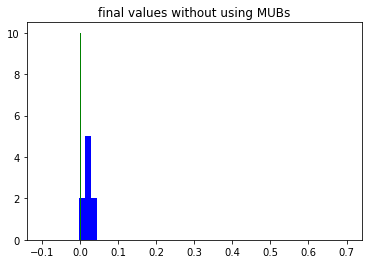

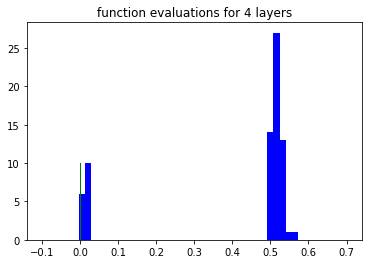

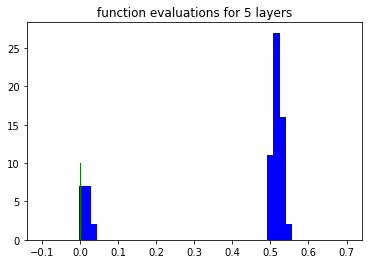

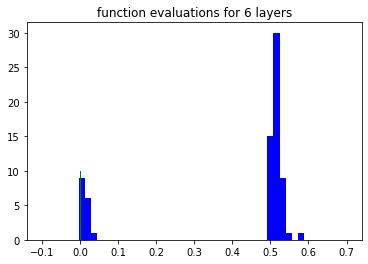

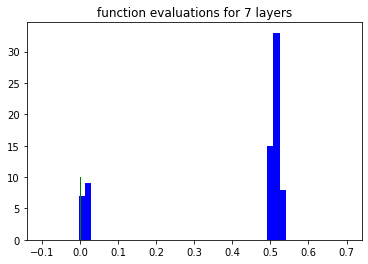

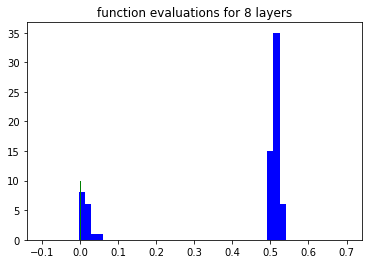

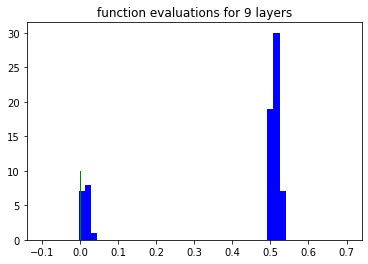

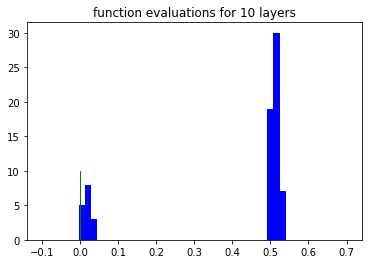

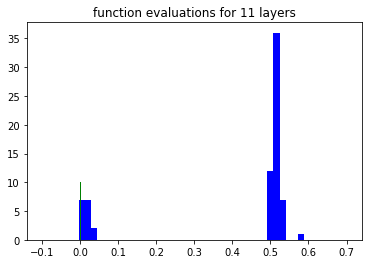

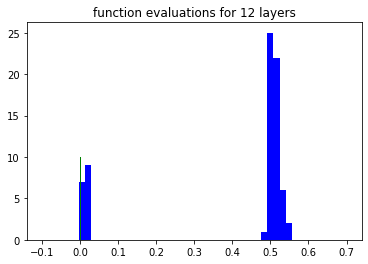

In [139]:
# plt.hist([layer['fin_val'] for layer in no_mub_stats.values()], 50, range=(-0.1, 0.5), density=True)
# plt.plot([0,0], [0,5])
# plt.title('final values without MUBS')
# plt.show()

# for layer, layer_stats in prepend_stats.items():
#     plt.hist(layer_stats['fin_vals'], 50, range=(-0.1, 0.5), density=True)

#     # Add Correct Result Line
#     plt.plot([0,0], [0,30], color='green', linewidth=1)
#     plt.title(f'function evaluations for {layer} layers')
#     plt.show()

myplot_heatmap([layer['fin_val'] for layer in no_mub_stats.values()], 0.0, title='final values without using MUBs', bin_count=50)
for layer, layer_stats in prepend_stats.items():
    myplot_heatmap(layer_stats['fin_vals'], 0.0, title=f'function evaluations for {layer} layers', bin_count=50)



### Minimal \# Of Function Evals

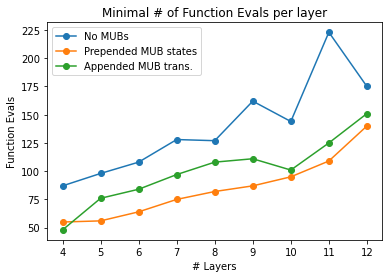

In [31]:
def plot_min_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    for v in stats_dict.values():
        assert 'min_nfev' in v.keys() or 'nfev' in v.keys()
    nfev_dict = {k: v['min_nfev'] if 'min_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Minimal # of Function Evals per layer')
plot_min_nfev(no_mub_stats, "No MUBs")
plot_min_nfev(prepend_stats, "Prepended MUB states")
plot_min_nfev(append_stats, "Appended MUB trans.")
plt.legend()
plt.show()

### Average \# Of Function Evals

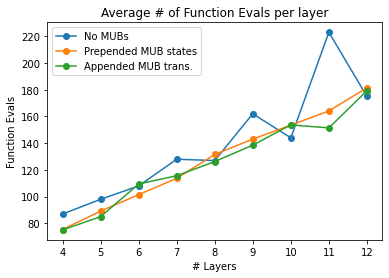

In [32]:
def plot_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    avg_nfev_dict = {k: v['avg_nfev'] if 'avg_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(avg_nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Average # of Function Evals per layer')
plot_avg_nfev(no_mub_stats, "No MUBs")
plot_avg_nfev(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Percent of Advantageous Additions

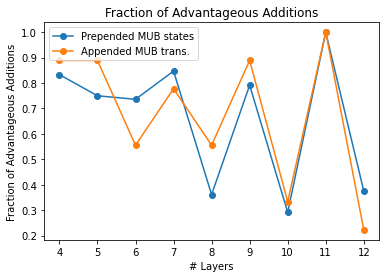

In [33]:
def plot_adv_percent(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_addition_percent'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Fraction of Advantageous Additions')
plt.title('Fraction of Advantageous Additions')
plot_adv_percent(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Average \# Of Function Evals in Advantageous Additions

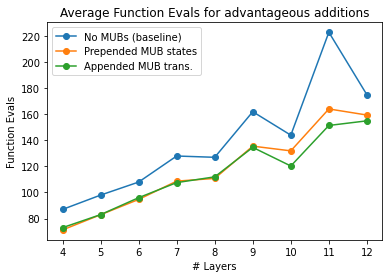

In [35]:
def plot_adv_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_avg_nfev'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Average Function Evals for advantageous additions')
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_adv_avg_nfev(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Summary: MUB Prepending

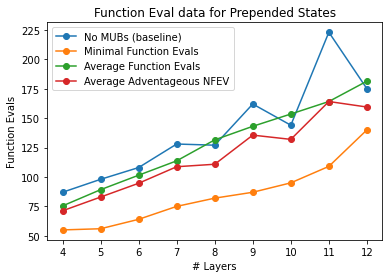

In [36]:
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_min_nfev(prepend_stats, 'Minimal Function Evals')
plot_avg_nfev(prepend_stats, 'Average Function Evals')
plot_adv_avg_nfev(prepend_stats, 'Average Adventageous NFEV')
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Function Eval data for Prepended States')
plt.legend()
plt.show()

## Basic Barren Plateau Circuit for Transverse Ising VQE
To save myself some time, I'll just use the built-in VQE module.

In [108]:
def build_pauli_string(n_qubits: int, mat_locations: Dict[int, str]) -> str:
    assert n_qubits > 0
    H = ''
    for i in range(n_qubits):
        H += mat_locations.get(i, 'I')
    return H

def generate_transverse_ising_ham(n_qubits: int) -> PauliSumOp:
    # Build Individual X strings
    string_list = [(build_pauli_string(n_qubits, {i: 'X'}), random()) for i in range(n_qubits)]
    for i in range(n_qubits):
        string_list += [(build_pauli_string(n_qubits, {i: 'Z', j: 'Z'}), random()) for j in range(i+1, n_qubits)]
    return PauliSumOp.from_list(string_list, 1)

In [105]:
## For now, I'm using the standard qiskit hardware efficient ansatz (as Dekel suggested).
def gen_hardware_eff_ansatz(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    ansatz = EfficientSU2(n_qubits, reps=n_layers, entanglement='linear')
    qc.compose(ansatz, inplace=True)
    return qc

### Experimenting without MUBs

#### Experiment Functions

In [106]:
# Returns the number of function evaluations it took for the method to converge.
def run_vqe_exp(ansatz: QuantumCircuit, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = 0.2) -> VQEResult:
    optimizer = COBYLA(tol=tol)
    vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=qi, initial_point=np.asarray(theta0))
    result = vqe.compute_minimum_eigenvalue(operator=ham)
    return result

#### Experiments

In [109]:
no_mub_res_vqe = {}

for n_layers in range(4, 13):
    print(f'RUNNING VQE EXPERIMENT FOR {n_layers} LAYERS:')
    # n_qubits = n_layers
    ham = generate_transverse_ising_ham(n_qubits)
    ansatz = gen_hardware_eff_ansatz(n_qubits, n_layers)
#     theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    theta0 = [0 for _ in range(ansatz.num_parameters)]
    layer_res = run_vqe_exp(ansatz, ham, theta0=theta0, tol=LO_TOL)
    no_mub_res_vqe[n_layers] = layer_res

RUNNING VQE EXPERIMENT FOR 4 LAYERS:
RUNNING VQE EXPERIMENT FOR 5 LAYERS:
RUNNING VQE EXPERIMENT FOR 6 LAYERS:
RUNNING VQE EXPERIMENT FOR 7 LAYERS:
RUNNING VQE EXPERIMENT FOR 8 LAYERS:
RUNNING VQE EXPERIMENT FOR 9 LAYERS:
RUNNING VQE EXPERIMENT FOR 10 LAYERS:
RUNNING VQE EXPERIMENT FOR 11 LAYERS:
RUNNING VQE EXPERIMENT FOR 12 LAYERS:


In [110]:
eigen_values, eigen_vectors = np.linalg.eigh(ham.to_matrix())

In [67]:
exact_result = eigen_values[0]
print(f"The exact result is: {exact_result}")
print(f"The excited states are: {eigen_values[1:]}")

The exact result is: -2.611073908575124
The excited states are: [-1.75710396 -0.76553487 -0.13554306  0.18934452  0.5137937   1.90793569
  2.65818189]


#### Analysis

In [102]:
# calculate the error from the exact result
for i in range(4, 13):
    print("Error for layer number " + str(i) +": " + str(abs(no_mub_res_vqe[i].eigenvalue - exact_result)))

Error for layer number 4: 0.24741949013293674
Error for layer number 5: 0.42165700401507644
Error for layer number 6: 0.6261742020762586
Error for layer number 7: 0.4706022584405041
Error for layer number 8: 0.21401529415827358
Error for layer number 9: 1.1897460560061148
Error for layer number 10: 0.36511685386935877
Error for layer number 11: 0.055285308974512226
Error for layer number 12: 0.1638953533226779


{4: {'nfev': 229, 'fin_val': (-2.027443183670129+0j)}, 5: {'nfev': 293, 'fin_val': (-1.5402271124059832+0j)}, 6: {'nfev': 309, 'fin_val': (-1.1792177736702125+0j)}, 7: {'nfev': 337, 'fin_val': (-2.012546808834031+0j)}, 8: {'nfev': 437, 'fin_val': (-1.7079952018227127+0j)}, 9: {'nfev': 469, 'fin_val': (-1.3832041412756813+0j)}, 10: {'nfev': 497, 'fin_val': (-2.0967624642075164+0j)}, 11: {'nfev': 401, 'fin_val': (-1.7217298852880814+0j)}, 12: {'nfev': 557, 'fin_val': (-1.7494133935917557+0j)}}


/Users/ittayalfassi/opt/anaconda3/envs/qiskit/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/ittayalfassi/opt/anaconda3/envs/qiskit/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


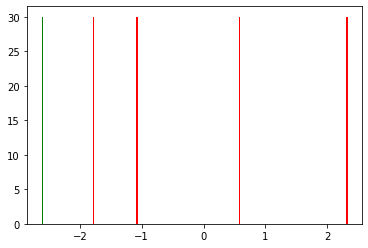

[(-2.027443183670129+0j),
 (-1.5402271124059832+0j),
 (-1.1792177736702125+0j),
 (-2.012546808834031+0j),
 (-1.7079952018227127+0j),
 (-1.3832041412756813+0j),
 (-2.0967624642075164+0j),
 (-1.7217298852880814+0j),
 (-1.7494133935917557+0j)]

In [112]:
filename = os.path.join(os.getcwd(), 'VQE results', NO_MUB_PATH)
no_mub_stats = gen_statistics_nomub(no_mub_res_vqe, filename=filename)
print(no_mub_stats)
myplot_heatmap([layer['fin_val'] for layer in no_mub_stats.values()], exact_result, eigen_values[1:])


### Experimenting with MUBs - prepending (VQE)

#### Experiment Functions

In [140]:
def run_vqe_exp_with_mub_prepend(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit, n_qubits: int, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = 0.2) -> dict:
    mub_qc = mub_qc.copy()
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None

    res_dict = {}
    for i in range((2 ** n_qubits)):
        starting_qc = get_comp_state_circ(i, n_qubits)
        full_qc = starting_qc.compose(mub_ansatz_qc, qubits=range(n_qubits), inplace=False)
        assert full_qc != None
        res_dict[i] = run_vqe_exp(full_qc, ham, theta0=theta0, tol=tol)

    return res_dict

#### Experiments

In [141]:
print('=====Experimenting with prepended MUB states=====')
ham = generate_transverse_ising_ham(n_qubits)
all_prepend_mub_results_vqe = {}

for n_layers in range(4,13):
    print(f'---experimenting with {n_layers} layers---')
    layer_results_vqe = {}
    ansatz = gen_hardware_eff_ansatz(n_qubits, n_layers)
    theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    for i, mub_circuit in enumerate(circuits):
        print(f'experimenting with MUB #{i+1}')
        res = run_vqe_exp_with_mub_prepend(ansatz, mub_circuit, n_qubits, ham, theta0=theta0, tol=LO_TOL)
        print(f'MUB #{i+1} done')
        layer_results_vqe[i] = res
    all_prepend_mub_results_vqe[n_layers] = layer_results_vqe

=====Experimenting with prepended MUB states=====
---experimenting with 4 layers---
experimenting with MUB #1
MUB #1 done
experimenting with MUB #2
MUB #2 done
experimenting with MUB #3
MUB #3 done
experimenting with MUB #4
MUB #4 done
experimenting with MUB #5
MUB #5 done
experimenting with MUB #6
MUB #6 done
experimenting with MUB #7
MUB #7 done
experimenting with MUB #8
MUB #8 done
experimenting with MUB #9
MUB #9 done
---experimenting with 5 layers---
experimenting with MUB #1
MUB #1 done
experimenting with MUB #2
MUB #2 done
experimenting with MUB #3
MUB #3 done
experimenting with MUB #4
MUB #4 done
experimenting with MUB #5
MUB #5 done
experimenting with MUB #6
MUB #6 done
experimenting with MUB #7
MUB #7 done
experimenting with MUB #8
MUB #8 done
experimenting with MUB #9
MUB #9 done
---experimenting with 6 layers---
experimenting with MUB #1
MUB #1 done
experimenting with MUB #2
MUB #2 done
experimenting with MUB #3
MUB #3 done
experimenting with MUB #4
MUB #4 done
experimentin

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

### Note
I changed the random initial state for layers 4,5,12 and 6,7,8 and 9,10,11 to see that the result is changing drastically by the random choice

In [96]:
for key in all_prepend_mub_results_vqe.keys():
    for key2 in all_prepend_mub_results_vqe[key].keys():
        for key3 in all_prepend_mub_results_vqe[key][key2].keys():
            print("num of layers: " + str(key), "MUB number: " + str(key2), "State number: " + str(key3), 
                  "eigenvalue: " + str(all_prepend_mub_results_vqe[key][key2][key3].eigenvalue))

num of layers: 4 MUB number: 0 State number: 0 eigenvalue: (-2.165086072516979+0j)
num of layers: 4 MUB number: 0 State number: 1 eigenvalue: (-2.166764693819764+0j)
num of layers: 4 MUB number: 0 State number: 2 eigenvalue: (-2.0942047157741626+0j)
num of layers: 4 MUB number: 0 State number: 3 eigenvalue: (-2.1590636241483874+0j)
num of layers: 4 MUB number: 0 State number: 4 eigenvalue: (-2.1073285077961788+0j)
num of layers: 4 MUB number: 0 State number: 5 eigenvalue: (-2.1631051711140934+0j)
num of layers: 4 MUB number: 0 State number: 6 eigenvalue: (-2.1302607038354866+0j)
num of layers: 4 MUB number: 0 State number: 7 eigenvalue: (-2.024229168672065+0j)
num of layers: 4 MUB number: 1 State number: 0 eigenvalue: (-2.1263081289833834+0j)
num of layers: 4 MUB number: 1 State number: 1 eigenvalue: (-2.1985027870922313+0j)
num of layers: 4 MUB number: 1 State number: 2 eigenvalue: (-2.083781303609044+0j)
num of layers: 4 MUB number: 1 State number: 3 eigenvalue: (-2.0560445356423576+

num of layers: 10 MUB number: 6 State number: 4 eigenvalue: (-1.9336383203370342+0j)
num of layers: 10 MUB number: 6 State number: 5 eigenvalue: (-1.9442769510977236+0j)
num of layers: 10 MUB number: 6 State number: 6 eigenvalue: (-1.93372628501456+0j)
num of layers: 10 MUB number: 6 State number: 7 eigenvalue: (-1.9175361617002067+0j)
num of layers: 10 MUB number: 7 State number: 0 eigenvalue: (-1.9278639881016155+0j)
num of layers: 10 MUB number: 7 State number: 1 eigenvalue: (-1.9242470526612998+0j)
num of layers: 10 MUB number: 7 State number: 2 eigenvalue: (-1.937944269988273+0j)
num of layers: 10 MUB number: 7 State number: 3 eigenvalue: (-1.9412607445546226+0j)
num of layers: 10 MUB number: 7 State number: 4 eigenvalue: (-1.9196051262371645+0j)
num of layers: 10 MUB number: 7 State number: 5 eigenvalue: (-1.8747837990318401+0j)
num of layers: 10 MUB number: 7 State number: 6 eigenvalue: (-1.8833316491662997+0j)
num of layers: 10 MUB number: 7 State number: 7 eigenvalue: (-1.8896

#### Analysis

In [ ]:
filename = os.path.join(os.getcwd(), 'VQE results', PRE_MUB_PATH)
prepend_stats = gen_statistics_prepending(all_prepend_mub_results_vqe, no_mub_stats, filename=filename)

### Experimenting with MUBs - appending

#### Experiment Functions

In [90]:
def run_vqe_exp_with_mub_append(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit, n_qubits: int, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = 0.2) -> VQEResult:
    mub_qc = mub_qc.copy()
    mub_ansatz_qc = ansatz_qc.compose(mub_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None
    
    return run_vqe_exp(mub_ansatz_qc, ham, theta0, tol)

#### Experiments

In [91]:
print('=====Experimenting with appended MUB states=====')
ham = generate_transverse_ising_ham(n_qubits)
all_append_mub_results = {}

for n_layers in range(4,13):
    print(f'---experimenting with {n_layers} layers---')
    layer_results = {}
    ansatz = gen_hardware_eff_ansatz(n_qubits, n_layers)
    theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    for i, mub_circuit in enumerate(circuits):
        print(f'experimenting with MUB #{i+1}')
        res = run_vqe_exp_with_mub_append(ansatz, mub_circuit, n_qubits, ham, theta0=theta0, tol=0.2)
        # print(res)
        print(f'MUB #{i+1} done')
        layer_results[i] = res
    all_append_mub_results[n_layers] = layer_results

=====Experimenting with appended MUB states=====
---experimenting with 4 layers---
experimenting with MUB #1
MUB #1 done
experimenting with MUB #2
MUB #2 done
experimenting with MUB #3
MUB #3 done
experimenting with MUB #4
MUB #4 done
experimenting with MUB #5
MUB #5 done
experimenting with MUB #6
MUB #6 done
experimenting with MUB #7
MUB #7 done
experimenting with MUB #8
MUB #8 done
experimenting with MUB #9
MUB #9 done
---experimenting with 5 layers---
experimenting with MUB #1
MUB #1 done
experimenting with MUB #2
MUB #2 done
experimenting with MUB #3
MUB #3 done
experimenting with MUB #4
MUB #4 done
experimenting with MUB #5
MUB #5 done
experimenting with MUB #6
MUB #6 done
experimenting with MUB #7
MUB #7 done
experimenting with MUB #8
MUB #8 done
experimenting with MUB #9
MUB #9 done
---experimenting with 6 layers---
experimenting with MUB #1
MUB #1 done
experimenting with MUB #2
MUB #2 done
experimenting with MUB #3
MUB #3 done
experimenting with MUB #4
MUB #4 done
experimenting

#### Analysis

In [95]:
filename = os.path.join(os.getcwd(), 'VQE results', APP_MUB_PATH)
append_stats = gen_statistics_appending(all_append_mub_results, no_mub_stats, filename=filename)

## Collective Experiments - VQE

### (Optionally) Load Data Fom Files

In [97]:
from ast import literal_eval

STATS_FROM_FILES = False

def load_stats(name: str) -> dict:
    filename = os.path.join(os.getcwd(), 'VQE results', name)
    with open(filename, 'r') as f:
        data = f.read()
    
    return literal_eval(data)

if STATS_FROM_FILES:
    no_mub_stats = load_stats(NO_MUB_PATH)
    prepend_stats = load_stats(PRE_MUB_PATH)
    append_stats = load_stats(APP_MUB_PATH)

### Raw Summary Data

In [98]:
print('No MUBs:')
print(no_mub_stats)
print('Prepended MUB states:')
print(prepend_stats)
print('Appended MUB transformations:')
print(append_stats)

No MUBs:
{4: {'nfev': 121}, 5: {'nfev': 126}, 6: {'nfev': 168}, 7: {'nfev': 172}, 8: {'nfev': 189}, 9: {'nfev': 264}, 10: {'nfev': 220}, 11: {'nfev': 274}, 12: {'nfev': 273}}
Prepended MUB states:
{4: {'adv_addition_percent': 0.3472222222222222, 'adv_avg_nfev': 110.56, 'adv_states': {0: {1: 104, 2: 104, 5: 93}, 1: {1: 110, 6: 114}, 2: {}, 3: {2: 110, 5: 112, 7: 112}, 4: {1: 110, 2: 108, 3: 110, 5: 114, 6: 122}, 5: {4: 108, 5: 100}, 6: {1: 111, 6: 122, 7: 110}, 7: {0: 116, 4: 110, 6: 110, 7: 120}, 8: {1: 108, 4: 110, 6: 116}}, 'adv_states_count': 25, 'avg_nfev': 132.15277777777777, 'min_nfev': 93}, 5: {'adv_addition_percent': 0.2777777777777778, 'adv_avg_nfev': 128.8, 'adv_states': {0: {3: 130, 4: 128, 6: 118}, 1: {0: 136, 1: 122, 2: 132, 4: 134}, 2: {6: 126}, 3: {3: 124}, 4: {2: 130, 4: 133, 5: 130}, 5: {1: 126, 3: 126}, 6: {1: 134}, 7: {4: 128, 5: 132}, 8: {1: 135, 2: 128, 3: 124}}, 'adv_states_count': 20, 'avg_nfev': 152.33333333333334, 'min_nfev': 118}, 6: {'adv_addition_percent': 0

### Minimal \# Of Function Evals

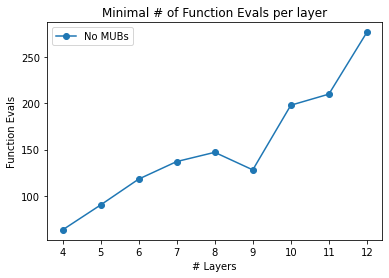

In [130]:
def plot_min_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    for v in stats_dict.values():
        assert 'min_nfev' in v.keys() or 'nfev' in v.keys()
    nfev_dict = {k: v['min_nfev'] if 'min_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Minimal # of Function Evals per layer')
plot_min_nfev(no_mub_stats, "No MUBs")
#plot_min_nfev(prepend_stats, "Prepended MUB states")
#plot_min_nfev(append_stats, "Appended MUB trans.")
plt.legend()
plt.show()

### Average \# Of Function Evals

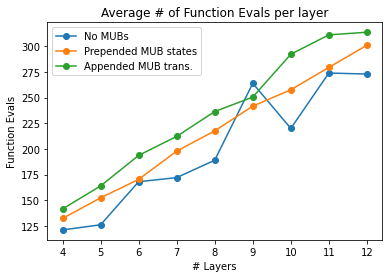

In [117]:
def plot_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    avg_nfev_dict = {k: v['avg_nfev'] if 'avg_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(avg_nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Average # of Function Evals per layer')
plot_avg_nfev(no_mub_stats, "No MUBs")
plot_avg_nfev(prepend_stats, "Prepended MUB states")
plot_avg_nfev(append_stats, "Appended MUB trans.")
plt.legend()
plt.show()

### Percent of Advantageous Additions

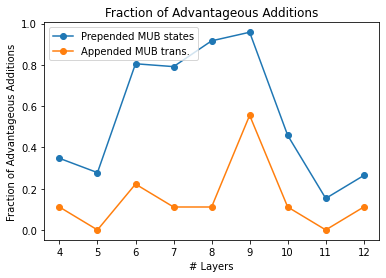

In [118]:
def plot_adv_percent(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_addition_percent'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Fraction of Advantageous Additions')
plt.title('Fraction of Advantageous Additions')
plot_adv_percent(prepend_stats, "Prepended MUB states")
plot_adv_percent(append_stats, "Appended MUB trans.")
plt.legend()
plt.show()

### Average \# Of Function Evals in Advantageous Additions

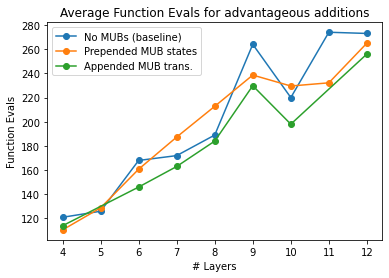

In [119]:
def plot_adv_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_avg_nfev'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Average Function Evals for advantageous additions')
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_adv_avg_nfev(prepend_stats, "Prepended MUB states")
plot_adv_avg_nfev(append_stats, "Appended MUB trans.")
plt.legend()
plt.show()

### Summary: MUB Prepending

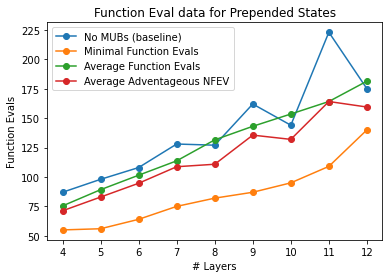

In [29]:
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_min_nfev(prepend_stats, 'Minimal Function Evals')
plot_avg_nfev(prepend_stats, 'Average Function Evals')
plot_adv_avg_nfev(prepend_stats, 'Average Adventageous NFEV')
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Function Eval data for Prepended States')
plt.legend()
plt.show()

### Summary: MUB Appending

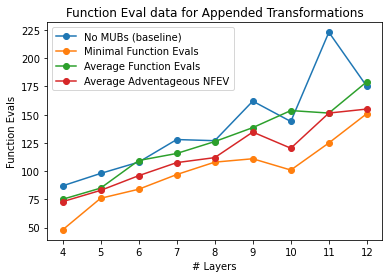

In [30]:
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_min_nfev(append_stats, 'Minimal Function Evals')
plot_avg_nfev(append_stats, 'Average Function Evals')
plot_adv_avg_nfev(append_stats, 'Average Adventageous NFEV')
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Function Eval data for Appended Transformations')
plt.legend()
plt.show()